# Import Libraries

In [ ]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
os.getcwd()

'/content'

# GPU

In [24]:
# setting device on GPU if available, else CPU
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda")
print('Using device:', device)
print()

#Additional Info when using cuda,
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.1 GB
Cached:    0.1 GB


In [25]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


In [26]:
torch.cuda.is_available()

True

# PATHS

In [29]:
DATA_PATH = '/content/drive/MyDrive/Kaggle/tyre_quality'
print("DATA_PATH = ",DATA_PATH)

TRAIN_PATH = os.path.join(DATA_PATH, "train/")
print("TRAIN_PATH = ", TRAIN_PATH)

VAL_PATH = os.path.join(DATA_PATH, "test/")
print("TEST_PATH = ",VAL_PATH)

DATA_PATH =  /content/drive/MyDrive/Kaggle/tyre_quality
TRAIN_PATH =  /content/drive/MyDrive/Kaggle/tyre_quality/train/
TEST_PATH =  /content/drive/MyDrive/Kaggle/tyre_quality/test/


# Plotting Distribution of Each Classes

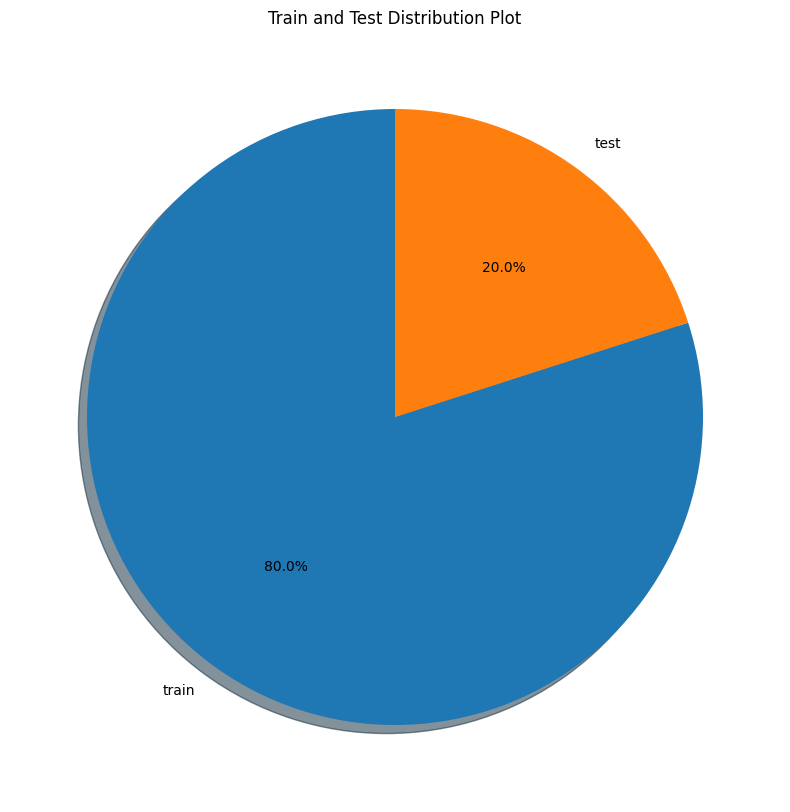

In [30]:
# class_names = os.listdir(DATA_PATH)
class_name_train = os.listdir(TRAIN_PATH)
class_name_val = os.listdir(VAL_PATH)
image_count_train = {}
image_count_val = {}

for i in class_name_train:
    image_count_train[i] = len(os.listdir(os.path.join(TRAIN_PATH,i)))

for i in class_name_val:
    image_count_val[i] = len(os.listdir(os.path.join(VAL_PATH,i)))

# print(image_count_train)

sum_train_images = 0
for k,v in image_count_train.items():
    sum_train_images += v

# print(sum_train_images)

sum_val_images = 0
for k,v in image_count_val.items():
     sum_val_images += v

# print(sum_val_images)

image_count = {'train': sum_train_images, 'test': sum_val_images}

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Train and Test Distribution Plot")
plt.show()

# Plotting Distribution of Train Classes

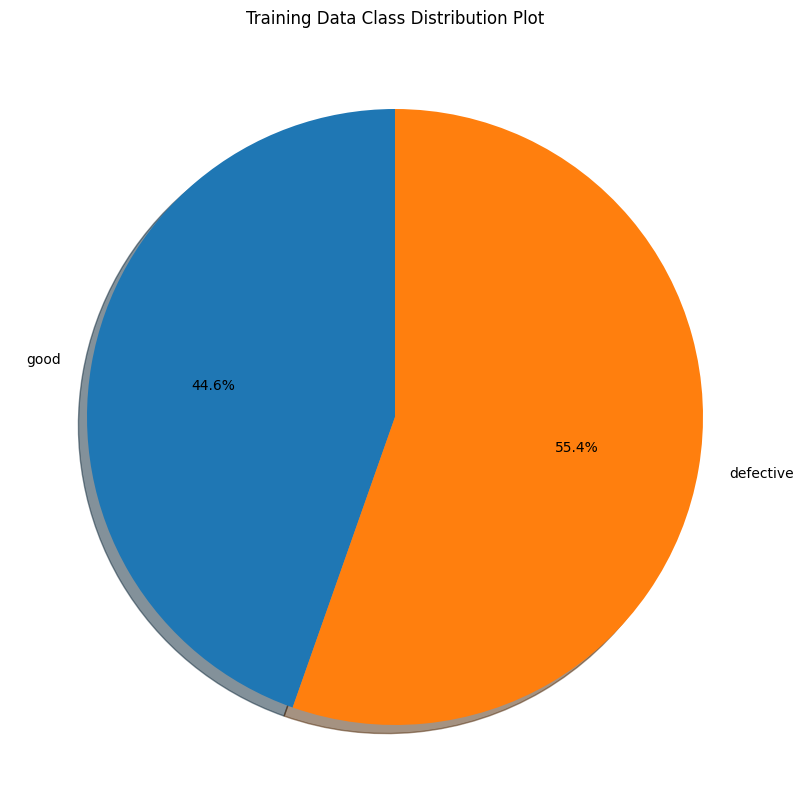

{'good': 662, 'defective': 822}


In [31]:
class_names = os.listdir(TRAIN_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(TRAIN_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Train Data Class Distribution Plot")
plt.show()
print(image_count)

# Plotting Distribution of Test Classes

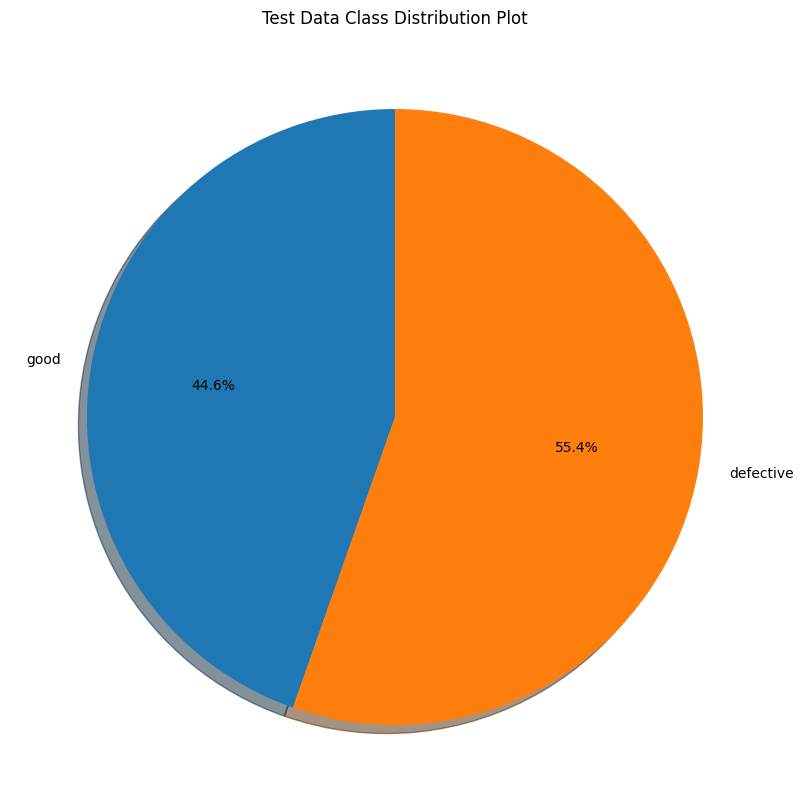

{'good': 166, 'defective': 206}


In [32]:
class_names = os.listdir(VAL_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(VAL_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Test Data Class Distribution Plot")
plt.show()
print(image_count)

# Data Loading

In [33]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((224,224)), #Resizes all images into same dimension
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "test": transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [34]:
def load_data(datadir):
    data = datasets.ImageFolder(datadir, transform=data_transforms['train'])
    dataloader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True)
    dataset_size = len(data)
    return dataloader, dataset_size

trainloader, dataset_size = load_data(TRAIN_PATH)
testloader, test_dataset_size = load_data(VAL_PATH)

dataloaders = {"train": trainloader, "val": testloader}
data_sizes = {"train": dataset_size, "val": test_dataset_size}

data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(data_sizes)
print(class_names)

{'train': 1484, 'val': 372}
['defective', 'good']


# Visualization of Train Samples

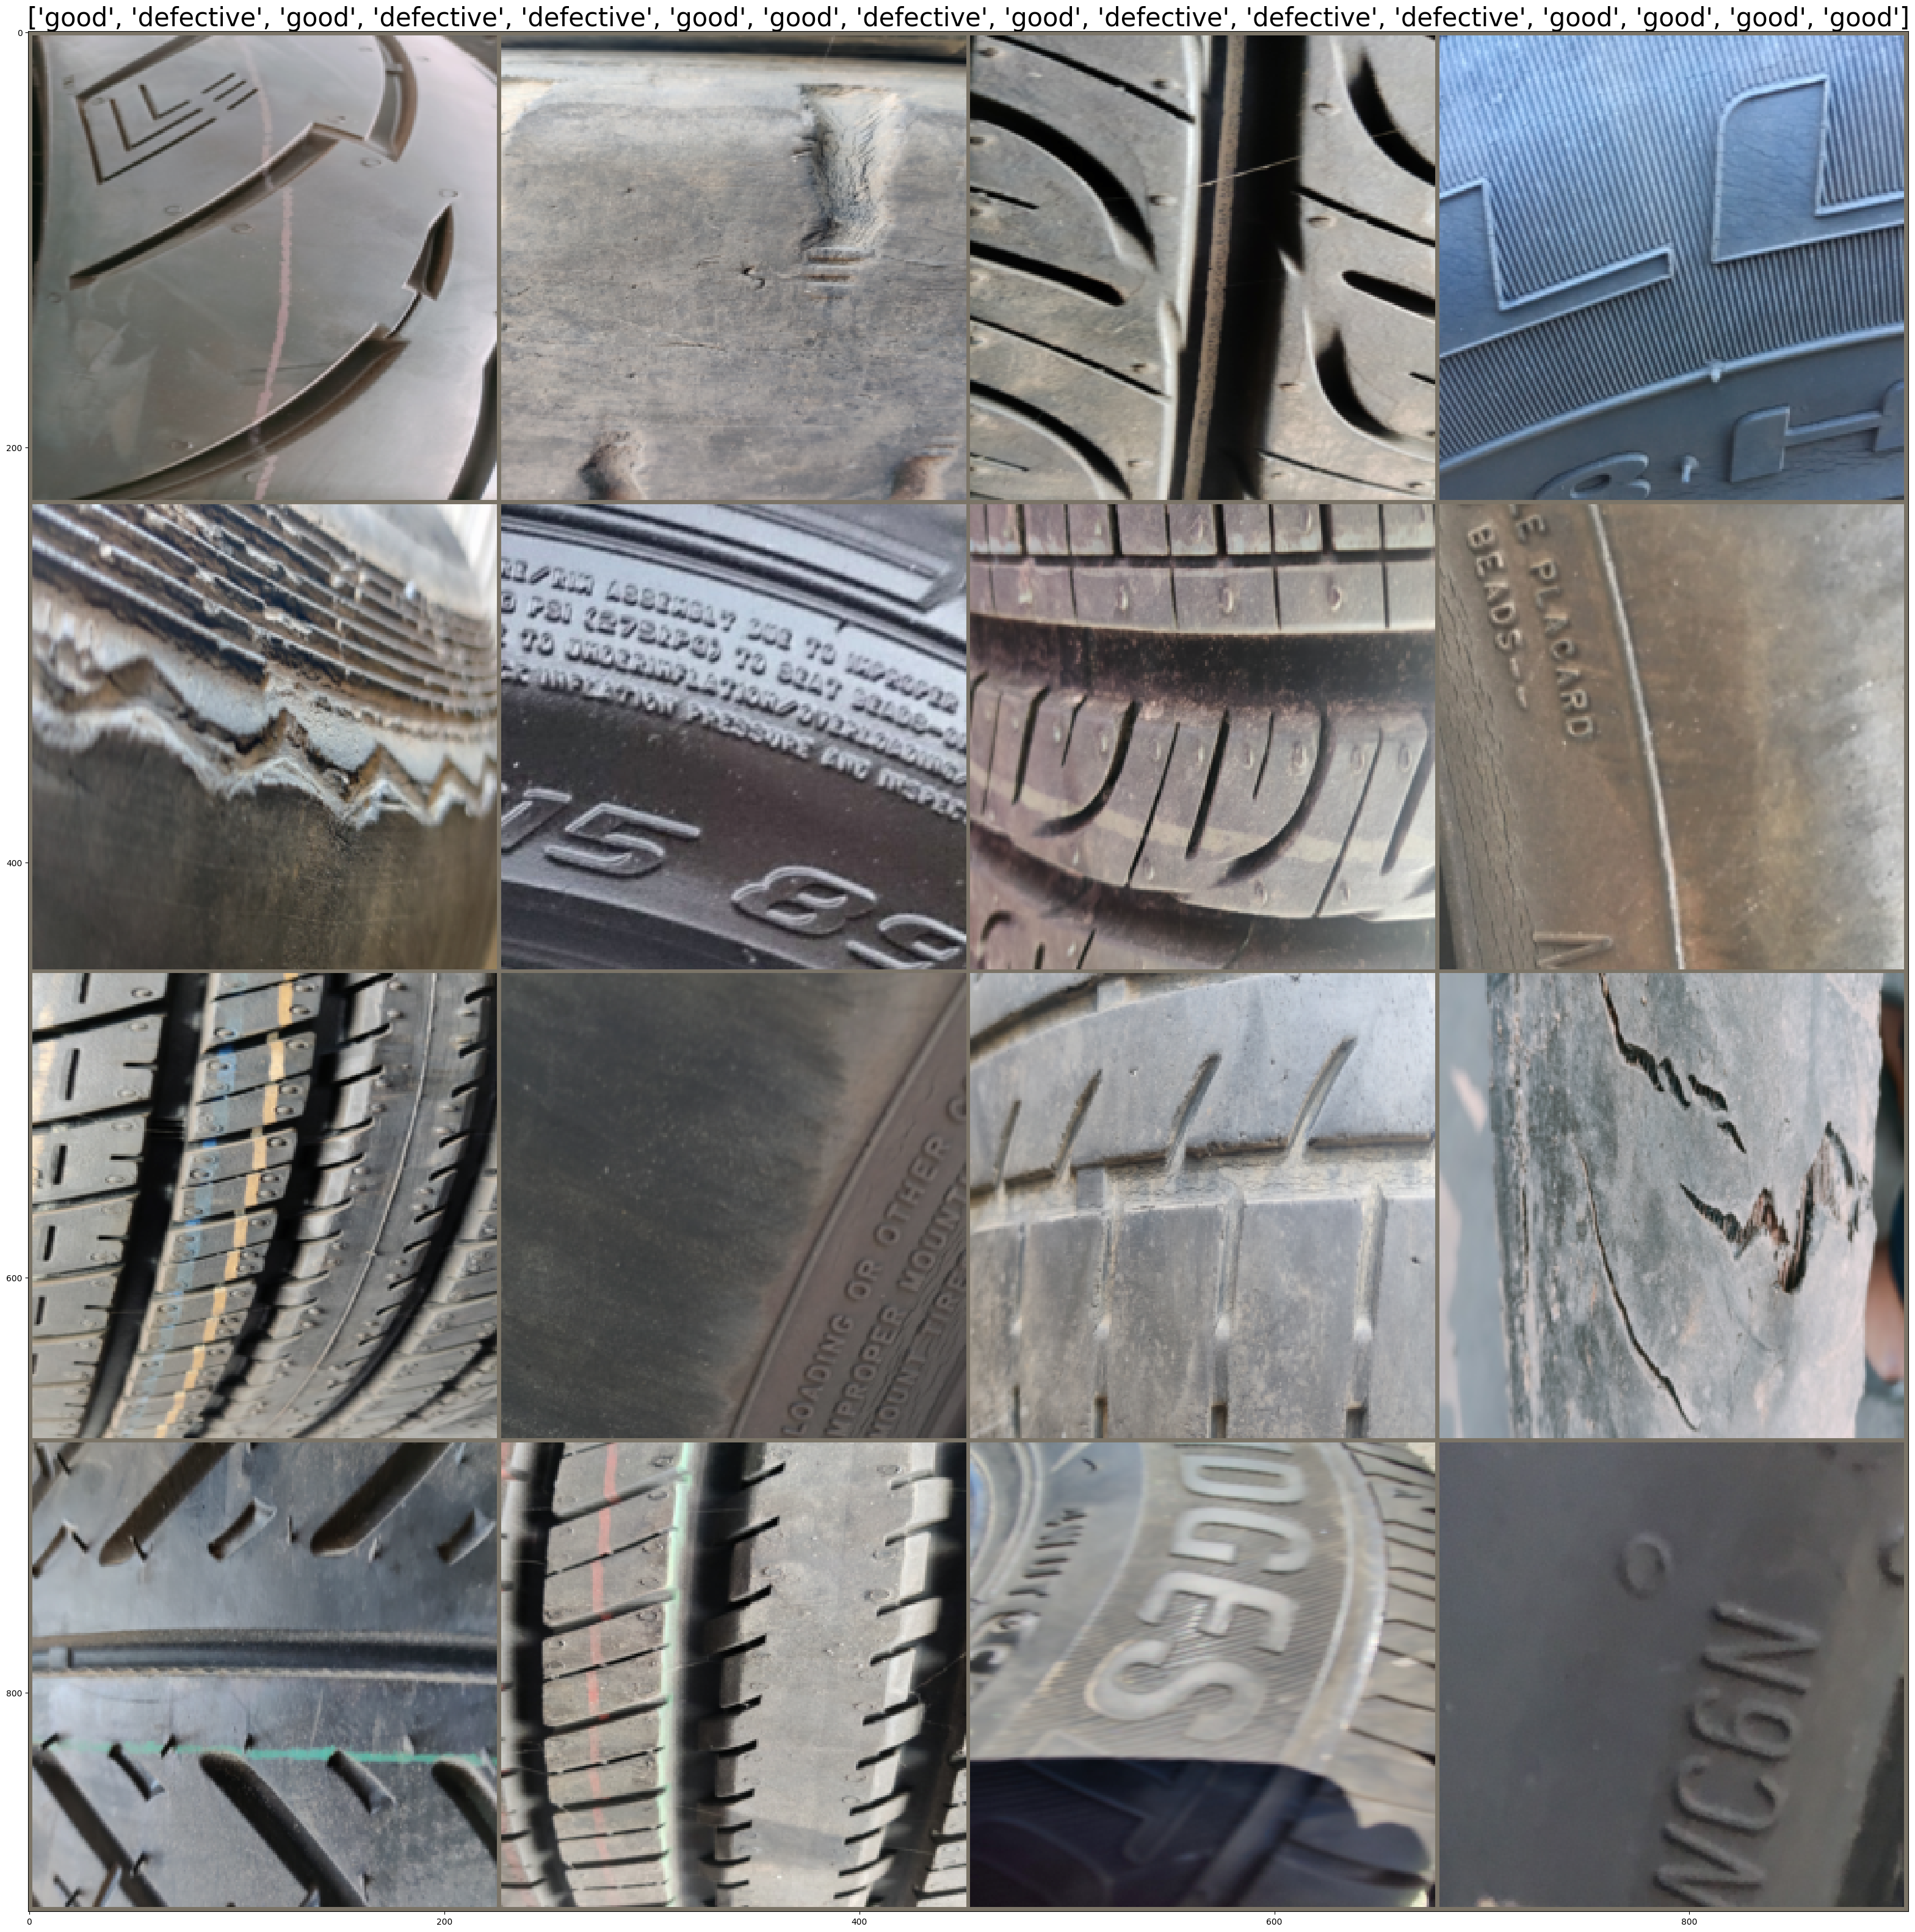

In [35]:
import matplotlib
def imshow(inp, size =(40,40), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data

inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow =  4, padding =  2, value_range = 1)



imshow(out, title=[class_names[x] for x in classes])


# # Get a batch of val data

# inputs, classes = next(iter(dataloaders['val']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

# DenseNet model

In [38]:
def CNN_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    #model = models.alexnet(pretrained=pretrained)
    model.eval()
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=429, gamma=0.1) # Learning Scheduler

In [39]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Training

In [ ]:
import math
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
                #print(val_kappa)
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
np.seterr(divide='ignore', invalid='ignore')
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=10)

Epoch 1/10
----------


train:   0%|          | 0/93 [00:00<?, ?it/s]

train Loss: 0.3433 | train Accuracy: 0.8612


val:   0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.2844 | val Accuracy: 0.9005 | Kappa Score: nan
Val loss Decreased from inf to 0.2844 
Saving Weights... 

Epoch 2/10
----------


train:   0%|          | 0/93 [00:00<?, ?it/s]

train Loss: 0.2629 | train Accuracy: 0.8935


val:   0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3355 | val Accuracy: 0.8656 | Kappa Score: 0.7321

Epoch 3/10
----------


train:   0%|          | 0/93 [00:00<?, ?it/s]

train Loss: 0.2539 | train Accuracy: 0.8949


val:   0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.8427 | val Accuracy: 0.8817 | Kappa Score: 0.7203

Epoch 4/10
----------


train:   0%|          | 0/93 [00:00<?, ?it/s]

train Loss: 0.2590 | train Accuracy: 0.8982


val:   0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.2199 | val Accuracy: 0.9005 | Kappa Score: 0.7931
Val loss Decreased from 0.2844 to 0.2199 
Saving Weights... 

Epoch 5/10
----------


train:   0%|          | 0/93 [00:00<?, ?it/s]

train Loss: 0.1453 | train Accuracy: 0.9495


val:   0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.1579 | val Accuracy: 0.9328 | Kappa Score: 0.8641
Val loss Decreased from 0.2199 to 0.1579 
Saving Weights... 

Epoch 6/10
----------


train:   0%|          | 0/93 [00:00<?, ?it/s]

train Loss: 0.1083 | train Accuracy: 0.9542


val:   0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.1465 | val Accuracy: 0.9355 | Kappa Score: 0.8675
Val loss Decreased from 0.1579 to 0.1465 
Saving Weights... 

Epoch 7/10
----------


train:   0%|          | 0/93 [00:00<?, ?it/s]

train Loss: 0.0799 | train Accuracy: 0.9710


val:   0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.1364 | val Accuracy: 0.9409 | Kappa Score: 0.8569
Val loss Decreased from 0.1465 to 0.1364 
Saving Weights... 

Epoch 8/10
----------


train:   0%|          | 0/93 [00:00<?, ?it/s]

train Loss: 0.0753 | train Accuracy: 0.9757


val:   0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.1236 | val Accuracy: 0.9543 | Kappa Score: 0.8913
Val loss Decreased from 0.1364 to 0.1236 
Saving Weights... 

Epoch 9/10
----------


train:   0%|          | 0/93 [00:00<?, ?it/s]

train Loss: 0.0527 | train Accuracy: 0.9852


val:   0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.1314 | val Accuracy: 0.9435 | Kappa Score: 0.8811

Epoch 10/10
----------


train:   0%|          | 0/93 [00:00<?, ?it/s]

train Loss: 0.0384 | train Accuracy: 0.9912


val:   0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.1377 | val Accuracy: 0.9355 | Kappa Score: 0.8472

Training complete in 27m 58s
Best val loss: 0.1236


In [ ]:
torch.save(model.state_dict(), "densenet.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Model Visualization

In [ ]:
def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} Predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (16,4))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

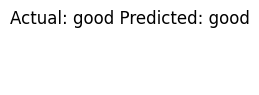

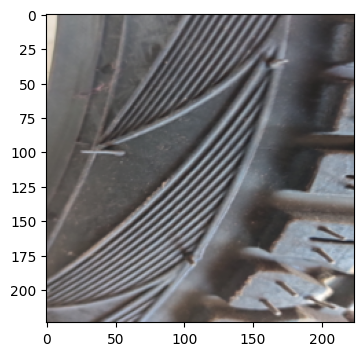

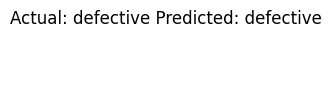

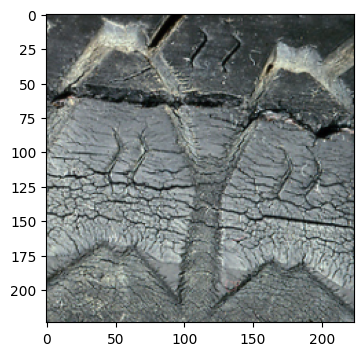

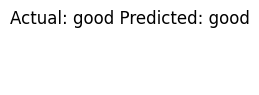

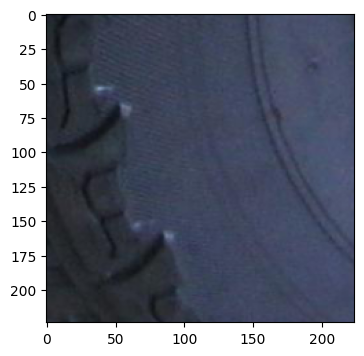

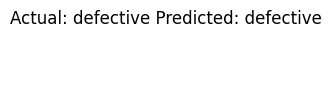

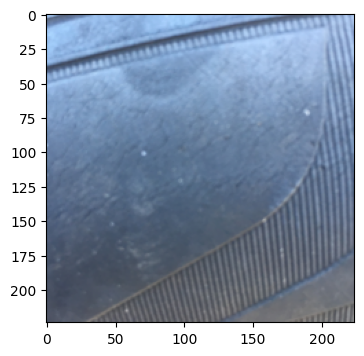

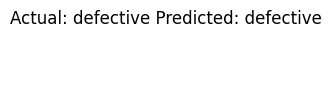

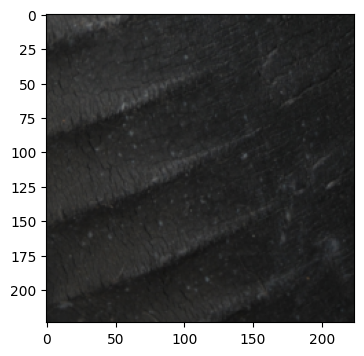

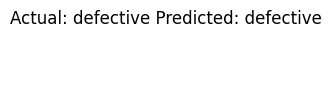

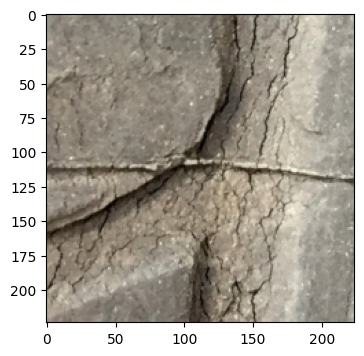

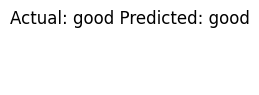

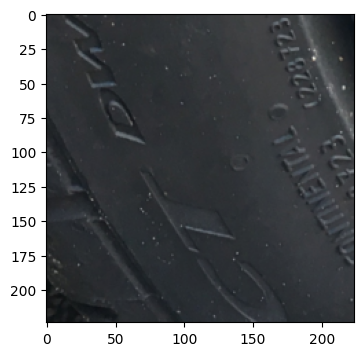

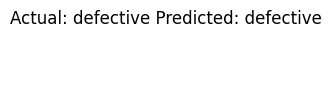

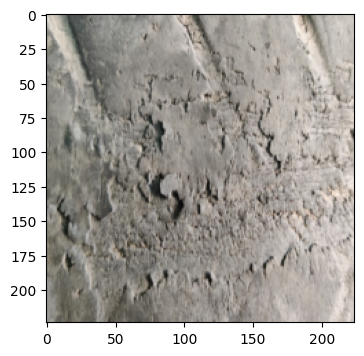

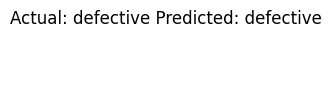

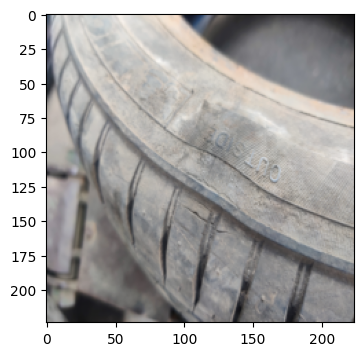

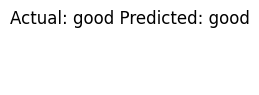

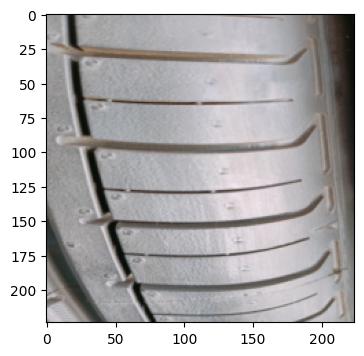

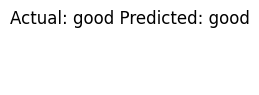

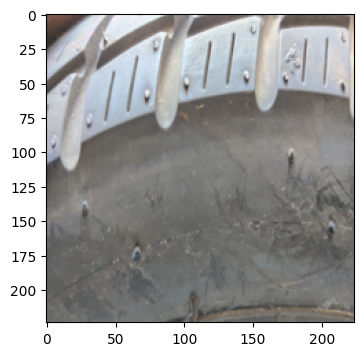

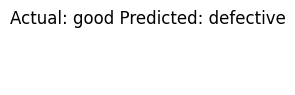

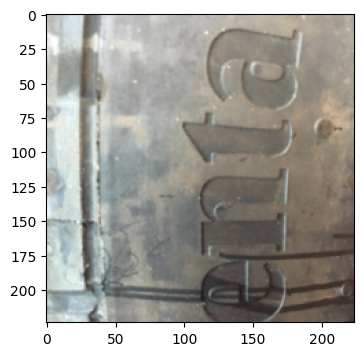

In [ ]:
visualize_model(base_model)
plt.show()


# Test Accuracy

In [ ]:
class_names

['defective', 'good']

In [ ]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

def test_model(model, dataloaders, device):
    CM = 0
    model.eval()

    # Değişkenleri başlangıçta sıfır olarak tanımlayın
    sumtp, sumfp, sumfn, sumtn = 0, 0, 0, 0

    with torch.no_grad():
        for data in dataloaders['val']:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs.data, 1)
            CM += confusion_matrix(labels.cpu(), preds.cpu(), labels=[0, 1])

        tp = CM[1][1]
        fp = CM[0][1]
        fn = CM[1][0]
        tn = CM[0][0]

        # Paydan sıfır hatasını önlemek için paydanı kontrol edin
        if (tp + sumfn) != 0:
            recall = tp / (tp + fn)
        else:
            recall = 0.0

        if (tp + sumfp) != 0:
            precision = tp / (tp + fp)
        else:
            precision = 0.0

        acc = np.sum(np.diag(CM)) / np.sum(CM)

        print('\nTestset Accuracy (mean): %f %%' % (100 * acc))
        print('Recall: %f' % recall)
        print('Precision: %f' % precision)

        return acc, CM



In [ ]:
acc, cm = test_model(model,dataloaders,device)
print(cm)
print("Accuracy",acc)


Testset Accuracy (mean): 95.430108 %
Recall: 0.945783
Precision: 0.951515
[[198   8]
 [  9 157]]
Accuracy 0.9543010752688172


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
class_names

['defective', 'good']

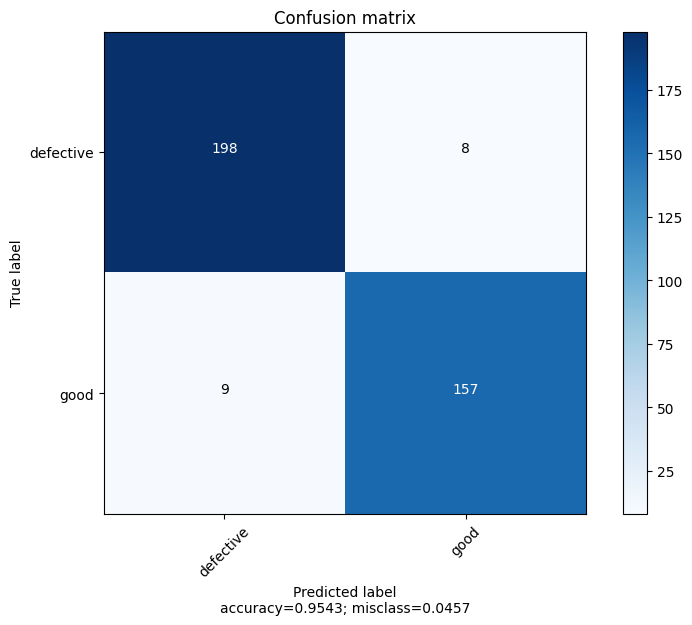

In [ ]:
from sklearn import metrics
plot_confusion_matrix(cm, target_names= ['defective', 'good'], title='Confusion matrix' , normalize=False)

# Using the saved model

In [40]:
model = models.densenet121()

# Load saved weights
checkpoint = torch.load('/content/densenet.pth') # pth file path
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [41]:
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [42]:
# Load image path
image_path = '/content/tyre2.jpg'  # image path

# Open the image and apply transformations
preprocess = transforms.Compose([
    transforms.Resize(256),           # Resize the image
    transforms.CenterCrop(224),       # Center Crop
    transforms.ToTensor(),            # Convert to tensor data
    transforms.Normalize(             # Normalize (Statistics Based on ImageNet Data for Normalisation)
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Open the image and process it by applying transformations
image = Image.open(image_path)
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

In [45]:

# Predict the image using your model
with torch.no_grad():
    output = model(input_batch)
    predicted_class = torch.argmax(output).item()

In [46]:
# Print the predicted class and result
print("Predicted class index:", predicted_class)
print("Predicted class name:", class_names[predicted_class])  # class_names should be a list of class names based on your model

Tahmin edilen sınıf indeksi: 0
Tahmin edilen sınıf adı: defective
